In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point
from scipy import interpolate
from scipy.stats import linregress

home_dir = '/glade/work/devond/'

import sys  
sys.path.insert(0, home_dir)

from functions import * 

crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

In [2]:
topo = xr.open_dataset('/glade/work/devond/AIS_masks/TOPO_CESM.nc')
topo = convert_lon(topo)
topo.to_netcdf('/glade/work/devond/AIS_masks/TOPO_CESM_lon.nc')

In [3]:
def get_timeseries(data, mask, season = None):
    data_ts = data * cesm_area*mask
    if season is not None:
        data_ts = data_ts.sel(time=data_ts['time.season']==season)
        if season == 'DJF':
            data_ts = fix_time(data_ts)
    data_ts = (data_ts * data_ts.time.dt.days_in_month*3600*24).groupby(data_ts.time.dt.year).sum() #kg/s to kg/year
    data_ts = data_ts.sum(dim = ['lat','lon'])/(10**12) #kg to Gt
    data_trend = linregress(data_ts.year.values, data_ts.mean(dim = 'ensemble').values)
    data_trend_line = data_trend.slope*data_ts.year.values + data_trend.intercept
    
    return data_ts, data_trend, data_trend_line

In [4]:
### ----- Read ICE SHEET MASK data ----- ###

cesm_mask_file = '/glade/work/devond/AIS_masks/model_masks/CESM_masks.nc'
cesm_masks = xr.open_dataset(cesm_mask_file)
cesm_masks = cesm_masks.sel(lat = slice(-90,-60))
cesm_area = cesm_masks.area.values #grid cell areas
cesm_ism = cesm_masks.full_ism.values
cesm_gism = cesm_masks.grounded_ism.values

cesm_iceshelves = xr.open_dataset('/glade/work/devond/AIS_masks/iceshelfmask_CESM2.nc')
cesm_iceshelves = cesm_iceshelves.sel(latitude = slice(-90,-60))
cesm_shelves = cesm_iceshelves.ism.values
cesm_shelves[cesm_shelves==0]=np.nan

In [5]:
## SSP1
ssp1_snow = xr.load_dataset(f'/glade/work/devond/CESM/snow/CESM2_SNOW_SSP1-2.6_2.nc')
ssp1_rain = xr.load_dataset(f'/glade/work/devond/CESM/rain/CESM2_RAIN_SSP1-2.6_2.nc')
ssp1_evap = xr.load_dataset(f'/glade/work/devond/CESM/evap_subl/CESM2_QSOIL_SSP1-2.6_2.nc')
ssp1_runoff = xr.load_dataset(f'/glade/work/devond/CESM/runoff/CESM2_QRUNOFF_SSP1-2.6.nc')
ssp1_melt = xr.load_dataset(f'/glade/work/devond/CESM/melt/CESM2_QSNOMELT_SSP1-2.6.nc')
ssp1_temp = xr.load_dataset(f'/glade/work/devond/CESM/temperature/CESM2_TREFHT_SSP1-2.6.nc')['TREFHT']-273.15

ssp1_smb = (ssp1_snow.SNOW + ssp1_rain.RAIN - ssp1_evap.QSOIL - ssp1_runoff.QRUNOFF) 
ssp1_precip = ssp1_snow.SNOW + ssp1_rain.RAIN

In [6]:
#grounded
ssp1_smb_ts, ssp1_trend, ssp1_trend_line = get_timeseries(ssp1_smb, cesm_gism)
ssp1_precip_ts, ssp1_precip_trend, ssp1_precip_line = get_timeseries(ssp1_precip, cesm_gism)
ssp1_rain_ts, ssp1_rain_trend, ssp1_rain_line = get_timeseries(ssp1_rain.RAIN, cesm_gism)
ssp1_snow_ts, ssp1_snow_trend, ssp1_snow_line = get_timeseries(ssp1_snow.SNOW, cesm_gism)
ssp1_evap_ts, ssp1_evap_trend, ssp1_evap_line = get_timeseries(ssp1_evap.QSOIL, cesm_gism)
ssp1_runoff_ts, ssp1_runoff_trend, ssp1_runoff_line = get_timeseries(ssp1_runoff.QRUNOFF, cesm_gism)
ssp1_evap_ts, ssp1_evap_trend, ssp1_evap_line = get_timeseries(ssp1_evap.QSOIL, cesm_gism)
ssp1_temp_ts = (ssp1_temp * cesm_gism).groupby(ssp1_temp.time.dt.year).mean().mean(dim = 'ensemble')
ssp1_temp_ts = (ssp1_temp_ts*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_gism)

#ice shelves
ssp1_smb_ts_is, ssp1_trend_is, ssp1_trend_line_is = get_timeseries(ssp1_smb, cesm_shelves)
ssp1_precip_ts_is, ssp1_precip_trend_is, ssp1_precip_line_is = get_timeseries(ssp1_precip, cesm_shelves)
ssp1_rain_ts_is, ssp1_rain_trend_is, ssp1_rain_line_is = get_timeseries(ssp1_rain.RAIN, cesm_shelves)
ssp1_snow_ts_is, ssp1_snow_trend_is, ssp1_snow_line_is = get_timeseries(ssp1_snow.SNOW, cesm_shelves)
ssp1_evap_ts_is, ssp1_evap_trend_is, ssp1_evap_line_is = get_timeseries(ssp1_evap.QSOIL, cesm_shelves)
ssp1_runoff_ts_is, ssp1_runoff_trend_is, ssp1_runoff_line_is = get_timeseries(ssp1_runoff.QRUNOFF, cesm_shelves)
ssp1_melt_ts_is, ssp1_melt_trend_is, ssp1_melt_line_is = get_timeseries(ssp1_melt.QSNOMELT, cesm_shelves)
ssp1_temp_ts_is = (ssp1_temp * cesm_shelves).groupby(ssp1_temp.time.dt.year).mean().mean(dim = 'ensemble')
ssp1_temp_ts_is = (ssp1_temp_ts_is*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_shelves)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
## SSP3
ssp3_snow = xr.load_dataset(f'/glade/work/devond/CESM/snow/CESM2_SNOW_SSP3-7.0_2.nc')
ssp3_rain = xr.load_dataset(f'/glade/work/devond/CESM/rain/CESM2_RAIN_SSP3-7.0_2.nc')
ssp3_evap = xr.load_dataset(f'/glade/work/devond/CESM/evap_subl/CESM2_QSOIL_SSP3-7.0_2.nc')
ssp3_runoff = xr.load_dataset(f'/glade/work/devond/CESM/runoff/CESM2_QRUNOFF_SSP3-7.0.nc')
ssp3_melt = xr.load_dataset(f'/glade/work/devond/CESM/melt/CESM2_QSNOMELT_SSP3-7.0.nc')
ssp3_temp = xr.load_dataset(f'/glade/work/devond/CESM/temperature/CESM2_TREFHT_SSP3-7.0.nc')['TREFHT']-273.15

ssp3_smb = (ssp3_snow.SNOW + ssp3_rain.RAIN - ssp3_evap.QSOIL - ssp3_runoff.QRUNOFF)
ssp3_precip = ssp3_snow.SNOW + ssp3_rain.RAIN

In [8]:
#grounded
ssp3_smb_ts, ssp3_trend, ssp3_trend_line = get_timeseries(ssp3_smb, cesm_gism)
ssp3_precip_ts, ssp3_precip_trend, ssp3_precip_line = get_timeseries(ssp3_precip, cesm_gism)
ssp3_rain_ts, ssp3_rain_trend, ssp3_rain_line = get_timeseries(ssp3_rain.RAIN, cesm_gism)
ssp3_snow_ts, ssp3_snow_trend, ssp3_snow_line = get_timeseries(ssp3_snow.SNOW, cesm_gism)
ssp3_evap_ts, ssp3_evap_trend, ssp3_evap_line = get_timeseries(ssp3_evap.QSOIL, cesm_gism)
ssp3_runoff_ts, ssp3_runoff_trend, ssp3_runoff_line = get_timeseries(ssp3_runoff.QRUNOFF, cesm_gism)
ssp3_melt_ts, ssp3_melt_trend, ssp3_melt_line = get_timeseries(ssp3_melt.QSNOMELT, cesm_gism)
ssp3_temp_ts = (ssp3_temp * cesm_gism).groupby(ssp3_temp.time.dt.year).mean().mean(dim = 'ensemble')
ssp3_temp_ts = (ssp3_temp_ts*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_gism)

#ice shelves
ssp3_smb_ts_is, ssp3_trend_is, ssp3_trend_line_is = get_timeseries(ssp3_smb, cesm_shelves)
ssp3_precip_ts_is, ssp3_precip_trend_is, ssp3_precip_line_is = get_timeseries(ssp3_precip, cesm_shelves)
ssp3_rain_ts_is, ssp3_rain_trend_is, ssp3_rain_line_is = get_timeseries(ssp3_rain.RAIN, cesm_shelves)
ssp3_snow_ts_is, ssp3_snow_trend_is, ssp3_snow_line_is = get_timeseries(ssp3_snow.SNOW, cesm_shelves)
ssp3_evap_ts_is, ssp3_evap_trend_is, ssp3_evap_line_is = get_timeseries(ssp3_evap.QSOIL, cesm_shelves)
ssp3_runoff_ts_is, ssp3_runoff_trend_is, ssp3_runoff_line_is = get_timeseries(ssp3_runoff.QRUNOFF, cesm_shelves)
ssp3_melt_ts_is, ssp3_melt_trend_is, ssp3_melt_line_is = get_timeseries(ssp3_melt.QSNOMELT, cesm_shelves)
ssp3_temp_ts_is = (ssp3_temp * cesm_shelves).groupby(ssp3_temp.time.dt.year).mean().mean(dim = 'ensemble')
ssp3_temp_ts_is = (ssp3_temp_ts_is*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_shelves)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [9]:
## SSP5
ssp5_snow = xr.load_dataset(f'/glade/work/devond/CESM/snow/CESM2_SNOW_SSP5-8.5_2.nc')
ssp5_rain = xr.load_dataset(f'/glade/work/devond/CESM/rain/CESM2_RAIN_SSP5-8.5_2.nc')
ssp5_evap = xr.load_dataset(f'/glade/work/devond/CESM/evap_subl/CESM2_QSOIL_SSP5-8.5_2.nc')
ssp5_runoff = xr.load_dataset(f'/glade/work/devond/CESM/runoff/CESM2_QRUNOFF_SSP5-8.5.nc')
ssp5_melt = xr.load_dataset(f'/glade/work/devond/CESM/melt/CESM2_QSNOMELT_SSP5-8.5.nc')
ssp5_temp = xr.load_dataset(f'/glade/work/devond/CESM/temperature/CESM2_TREFHT_SSP5-8.5.nc')['TREFHT']-273.15

ssp5_smb = (ssp5_snow.SNOW + ssp5_rain.RAIN - ssp5_evap.QSOIL - ssp5_runoff.QRUNOFF)
ssp5_precip = (ssp5_snow.SNOW + ssp5_rain.RAIN)

In [10]:
#grounded
ssp5_smb_ts, ssp5_trend, ssp5_trend_line = get_timeseries(ssp5_smb, cesm_gism)
ssp5_precip_ts, ssp5_precip_trend, ssp5_precip_line = get_timeseries(ssp5_precip, cesm_gism)
ssp5_rain_ts, ssp5_rain_trend, ssp5_rain_line = get_timeseries(ssp5_rain.RAIN, cesm_gism)
ssp5_snow_ts, ssp5_snow_trend, ssp5_snow_line = get_timeseries(ssp5_snow.SNOW, cesm_gism)
ssp5_evap_ts, ssp5_evap_trend, ssp5_evap_line = get_timeseries(ssp5_evap.QSOIL, cesm_gism)
ssp5_runoff_ts, ssp5_runoff_trend, ssp5_runoff_line = get_timeseries(ssp5_runoff.QRUNOFF, cesm_gism)
ssp5_melt_ts, ssp5_melt_trend, ssp5_melt_line = get_timeseries(ssp5_melt.QSNOMELT, cesm_gism)
ssp5_temp_ts = (ssp5_temp * cesm_gism).groupby(ssp5_temp.time.dt.year).mean().mean(dim = 'ensemble')
ssp5_temp_ts = (ssp5_temp_ts*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_gism)

#ice shelves
ssp5_smb_ts_is, ssp5_trend_is, ssp5_trend_line_is = get_timeseries(ssp5_smb, cesm_shelves)
ssp5_precip_ts_is, ssp5_precip_trend_is, ssp5_precip_line_is = get_timeseries(ssp5_precip, cesm_shelves)
ssp5_rain_ts_is, ssp5_rain_trend_is, ssp5_rain_line_is = get_timeseries(ssp5_rain.RAIN, cesm_shelves)
ssp5_snow_ts_is, ssp5_snow_trend_is, ssp5_snow_line_is = get_timeseries(ssp5_snow.SNOW, cesm_shelves)
ssp5_evap_ts_is, ssp5_evap_trend_is, ssp5_evap_line_is = get_timeseries(ssp5_evap.QSOIL, cesm_shelves)
ssp5_runoff_ts_is, ssp5_runoff_trend_is, ssp5_runoff_line_is = get_timeseries(ssp5_runoff.QRUNOFF, cesm_shelves)
ssp5_melt_ts_is, ssp5_melt_trend_is, ssp5_melt_line_is = get_timeseries(ssp5_melt.QSNOMELT, cesm_shelves)
ssp5_temp_ts_is = (ssp5_temp * cesm_shelves).groupby(ssp5_temp.time.dt.year).mean().mean(dim = 'ensemble')
ssp5_temp_ts_is = (ssp5_temp_ts_is*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_shelves)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


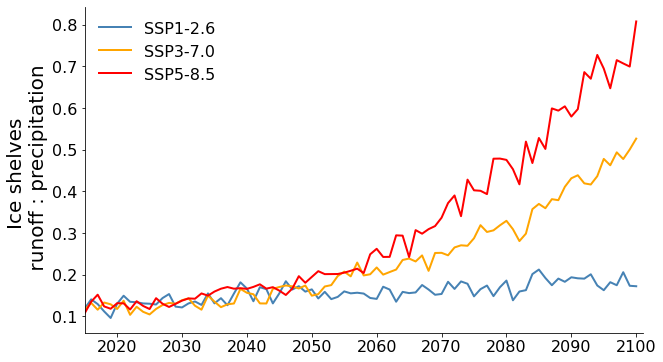

In [47]:
fig, ax = plt.subplots(1,1,figsize = (10,6))
plt.rcParams['axes.titlepad'] =14

ax.plot(ssp1_runoff_ts_is.year, ssp1_runoff_ts_is.mean(dim = 'ensemble')/ssp1_precip_ts_is.mean(dim = 'ensemble'), color = 'steelblue', linewidth = 2, label = 'SSP1-2.6')
ax.plot(ssp3_runoff_ts_is.year, ssp3_runoff_ts_is.mean(dim = 'ensemble')/ssp3_precip_ts_is.mean(dim = 'ensemble'), color = 'orange', linewidth = 2, label = 'SSP3-7.0')
ax.plot(ssp5_runoff_ts_is.year, ssp5_runoff_ts_is.mean(dim = 'ensemble')/ssp5_precip_ts_is.mean(dim = 'ensemble'), color = 'red', linewidth = 2, label = 'SSP5-8.5')
#ax.plot(ssp5_runoff_ts.year, ssp5_runoff_ts.mean(dim = 'ensemble')/ssp5_precip_ts.mean(dim = 'ensemble'), color = 'red', linewidth = 2, label = 'Grounded ice')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=16)
ax.set_xlim([2015,2101])
ax.set_ylabel('Ice shelves \n runoff : precipitation', fontsize = 20)
ax.legend(frameon = False,prop={'size': 16})
plt.savefig('runoff_precip.png', dpi = 300, bbox_inches = 'tight')

In [15]:
def plot_timeseries(data, ax, label = True):
    
    ax.plot(data[0].year, data[0].mean(dim = 'ensemble'), color = 'steelblue', linewidth = 2)
    ax.plot(data[1].year, data[1].mean(dim = 'ensemble'), color = 'orange', linewidth = 2)
    ax.plot(data[2].year, data[2].mean(dim = 'ensemble'), color = 'red', linewidth = 2)
    if label:ax.legend(['SSP1-2.6', 'SSP3-7.0', 'SSP5-8.5'],frameon = False,prop={'size': 15})
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(labelsize=14)
    

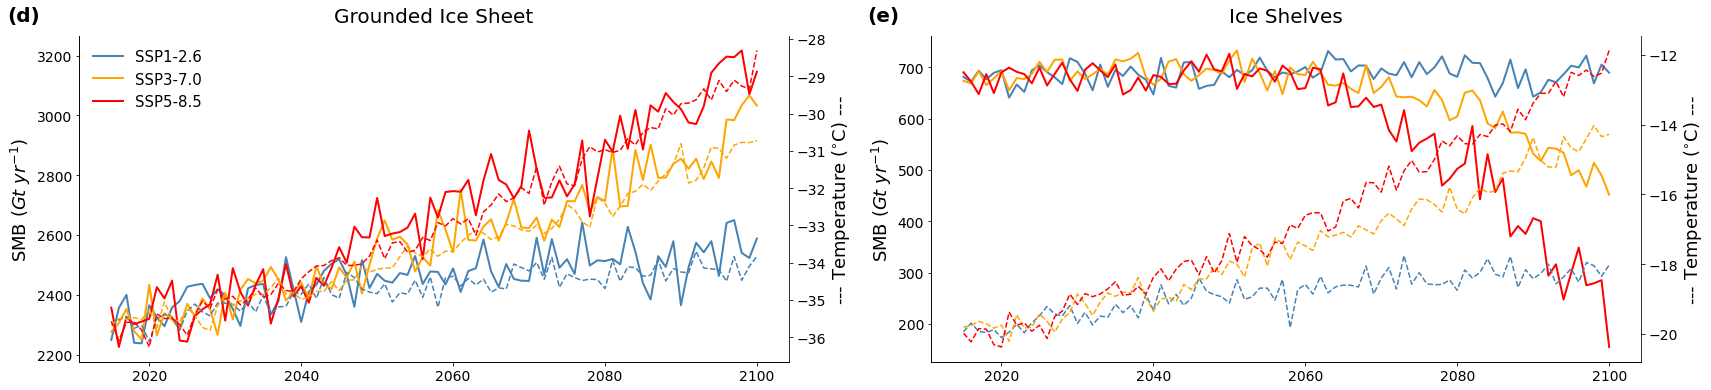

In [18]:
fig, ax = plt.subplots(1,2,figsize = (28,6))
plt.rcParams['axes.titlepad'] =14

plot_timeseries([ssp1_smb_ts, ssp3_smb_ts, ssp5_smb_ts], ax[0])
ax[0].set_title('Grounded Ice Sheet', fontsize = 20)
ax[0].set_ylabel('SMB ($Gt~yr^{-1}$)', fontsize = 18)
ax2 = plt.twinx(ax[0])
ax2.plot(ssp1_temp_ts.year, ssp1_temp_ts, '--', color = 'steelblue')
ax2.plot(ssp3_temp_ts.year, ssp3_temp_ts, '--', color = 'orange')
ax2.plot(ssp5_temp_ts.year, ssp5_temp_ts, '--', color = 'red')
ax2.spines["top"].set_visible(False)
ax2.tick_params(labelsize=14)
ax2.set_ylabel('--- Temperature ($^{\circ}$C) ---', fontsize = 18)
ax[0].text(-0.055, 1.09, '(d)', transform=ax[0].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plot_timeseries([ssp1_smb_ts_is, ssp3_smb_ts_is, ssp5_smb_ts_is], ax[1], label = False)
ax[1].set_title('Ice Shelves', fontsize = 20)
ax[1].set_ylabel('SMB ($Gt~yr^{-1}$)', fontsize = 18)
ax2 = plt.twinx(ax[1])
ax2.plot(ssp1_temp_ts_is.year, ssp1_temp_ts_is, '--', color = 'steelblue')
ax2.plot(ssp3_temp_ts_is.year, ssp3_temp_ts_is, '--', color = 'orange')
ax2.plot(ssp5_temp_ts_is.year, ssp5_temp_ts_is, '--', color = 'red')
ax2.spines["top"].set_visible(False)
ax2.tick_params(labelsize=14)
ax2.set_ylabel('--- Temperature ($^{\circ}$C) ---', fontsize = 18)
ax[1].text(-0.045, 1.09, '(e)', transform=ax[1].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
plt.savefig('smb_future.png', dpi = 300, bbox_inches = 'tight', transparent = True)



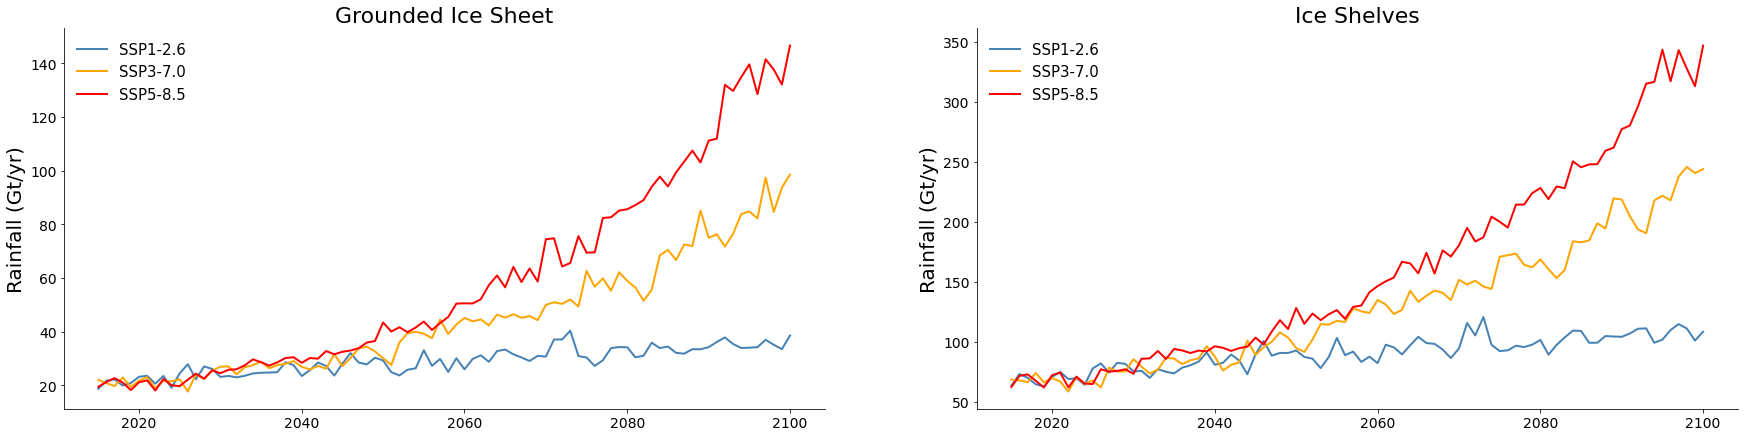

In [12]:
rain_data = [ssp1_rain_ts, ssp3_rain_ts, ssp5_rain_ts]
rain_data_is = [ssp1_rain_ts_is, ssp3_rain_ts_is, ssp5_rain_ts_is]
rain_trend_line = [ssp1_rain_line, ssp3_rain_line, ssp5_rain_line]
rain_trend = [ssp1_rain_trend, ssp3_rain_trend, ssp5_rain_trend]
# smb_trend_line_is = [ssp1_trend_line_is, ssp3_trend_line_is, ssp5_trend_line_is]
# smb_trend_is = [ssp1_trend_is, ssp3_trend_is, ssp5_trend_is]
plot_timeseries(rain_data, rain_data_is, 'Rainfall')
plt.savefig('rain_future.png', dpi = 300)

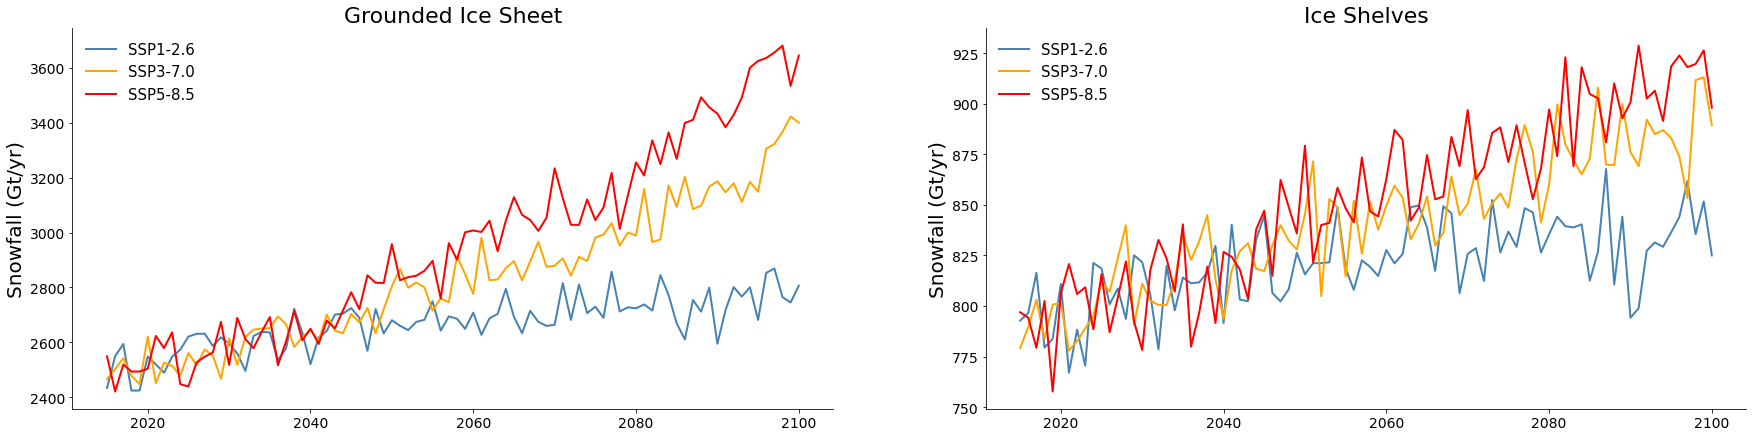

In [13]:
snow_data = [ssp1_snow_ts, ssp3_snow_ts, ssp5_snow_ts]
snow_data_is = [ssp1_snow_ts_is, ssp3_snow_ts_is, ssp5_snow_ts_is]
# rain_trend_line = [ssp1_rain_line, ssp3_rain_line, ssp5_rain_line]
# rain_trend = [ssp1_rain_trend, ssp3_rain_trend, ssp5_rain_trend]
# smb_trend_line_is = [ssp1_trend_line_is, ssp3_trend_line_is, ssp5_trend_line_is]
# smb_trend_is = [ssp1_trend_is, ssp3_trend_is, ssp5_trend_is]
plot_timeseries(snow_data, snow_data_is, 'Snowfall')
plt.savefig('snow_future.png', dpi = 300)

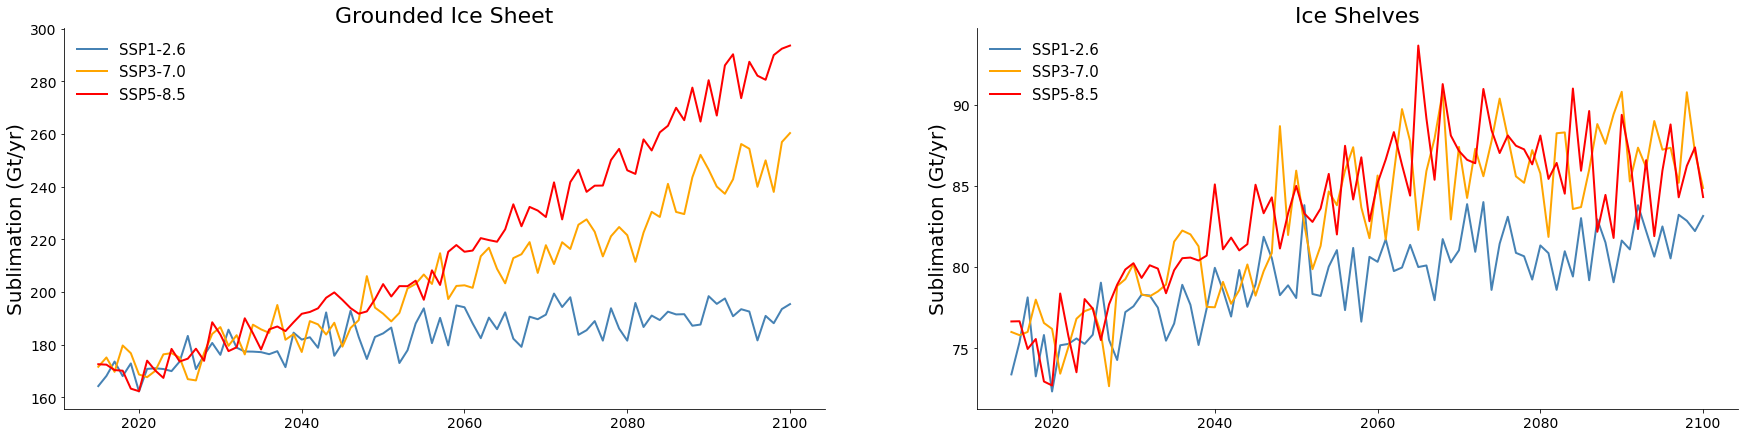

In [14]:
evap_data = [ssp1_evap_ts, ssp3_evap_ts, ssp5_evap_ts]
evap_data_is = [ssp1_evap_ts_is, ssp3_evap_ts_is, ssp5_evap_ts_is]
# evap_trend_line = [ssp1_evap_line, ssp3_evap_line, ssp5_evap_line]
# evap_trend = [ssp1_evap_trend, ssp3_evap_trend, ssp5_evap_trend]
# smb_trend_line_is = [ssp1_trend_line_is, ssp3_trend_line_is, ssp5_trend_line_is]
# smb_trend_is = [ssp1_trend_is, ssp3_trend_is, ssp5_trend_is]
plot_timeseries(evap_data, evap_data_is, 'Sublimation')
plt.savefig('sublimation_future.png', dpi = 300)

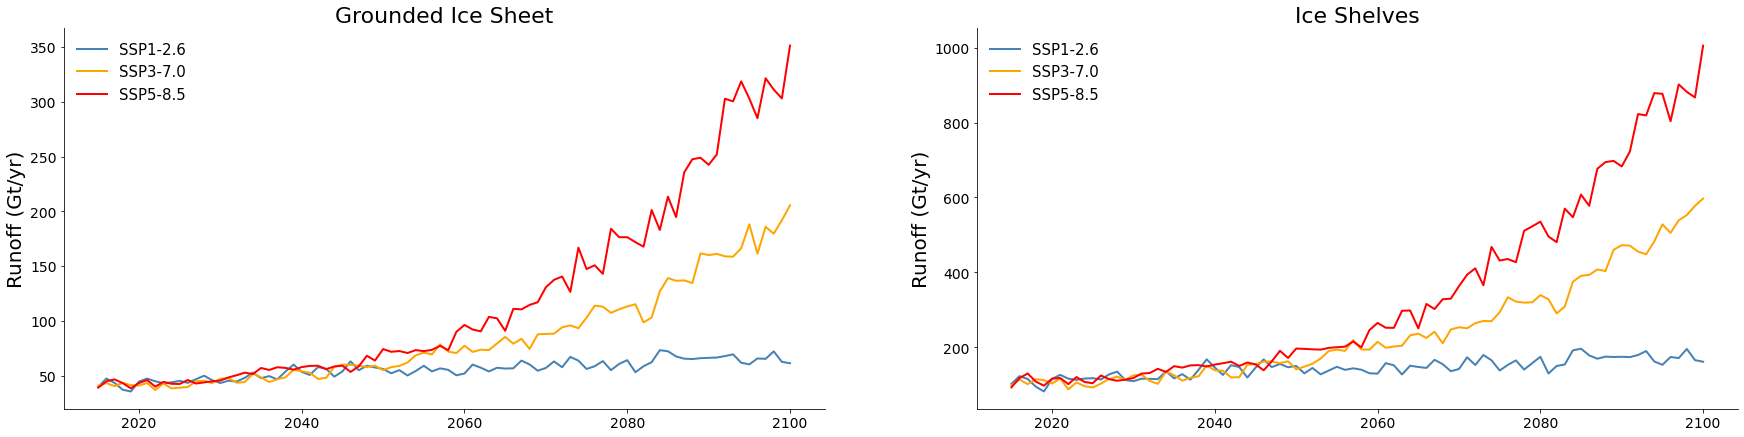

In [15]:
runoff_data = [ssp1_runoff_ts, ssp3_runoff_ts, ssp5_runoff_ts]
runoff_data_is = [ssp1_runoff_ts_is, ssp3_runoff_ts_is, ssp5_runoff_ts_is]
# evap_trend_line = [ssp1_evap_line, ssp3_evap_line, ssp5_evap_line]
# evap_trend = [ssp1_evap_trend, ssp3_evap_trend, ssp5_evap_trend]
# smb_trend_line_is = [ssp1_trend_line_is, ssp3_trend_line_is, ssp5_trend_line_is]
# smb_trend_is = [ssp1_trend_is, ssp3_trend_is, ssp5_trend_is]
plot_timeseries(runoff_data, runoff_data_is, 'Runoff')
plt.savefig('runoff_future.png', dpi = 300)

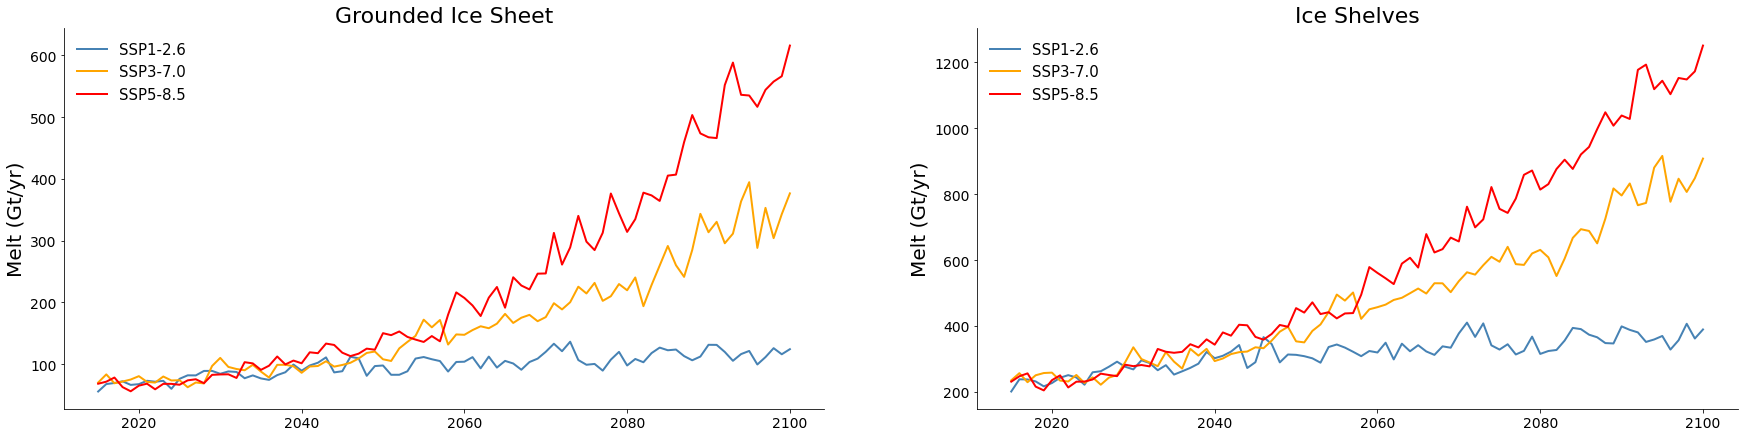

In [16]:
melt_data = [ssp1_melt_ts, ssp3_melt_ts, ssp5_melt_ts]
melt_data_is = [ssp1_melt_ts_is, ssp3_melt_ts_is, ssp5_melt_ts_is]
# evap_trend_line = [ssp1_evap_line, ssp3_evap_line, ssp5_evap_line]
# evap_trend = [ssp1_evap_trend, ssp3_evap_trend, ssp5_evap_trend]
# smb_trend_line_is = [ssp1_trend_line_is, ssp3_trend_line_is, ssp5_trend_line_is]
# smb_trend_is = [ssp1_trend_is, ssp3_trend_is, ssp5_trend_is]
plot_timeseries(melt_data, melt_data_is, 'Melt')
plt.savefig('melt_future.png', dpi = 300)

## Trends

In [19]:
ssp1_smb_map = (ssp1_smb * cesm_ism * ssp1_smb.time.dt.days_in_month*3600*24).groupby(ssp1_smb.time.dt.year).sum().mean(dim = 'ensemble')
ssp1_smb_trend, ssp1_p = calculate_trend(ssp1_smb_map.values)
lon = ssp1_smb.lon
lat = ssp1_smb.lat
ssp1_smb_trend, lon2 = add_cyclic_point(ssp1_smb_trend, coord = lon)

In [20]:
ssp3_smb_map = (ssp3_smb * cesm_ism * ssp3_smb.time.dt.days_in_month*3600*24).groupby(ssp3_smb.time.dt.year).sum().mean(dim = 'ensemble')
ssp3_smb_trend, ssp3_p = calculate_trend(ssp3_smb_map.values)
ssp3_smb_trend, lon2 = add_cyclic_point(ssp3_smb_trend, coord = lon)

In [21]:
ssp5_smb_map = (ssp5_smb * cesm_ism * ssp5_smb.time.dt.days_in_month*3600*24).groupby(ssp5_smb.time.dt.year).sum().mean(dim = 'ensemble')
ssp5_smb_trend, ssp5_p = calculate_trend(ssp5_smb_map.values)
ssp5_smb_trend, lon2 = add_cyclic_point(ssp5_smb_trend, coord = lon)

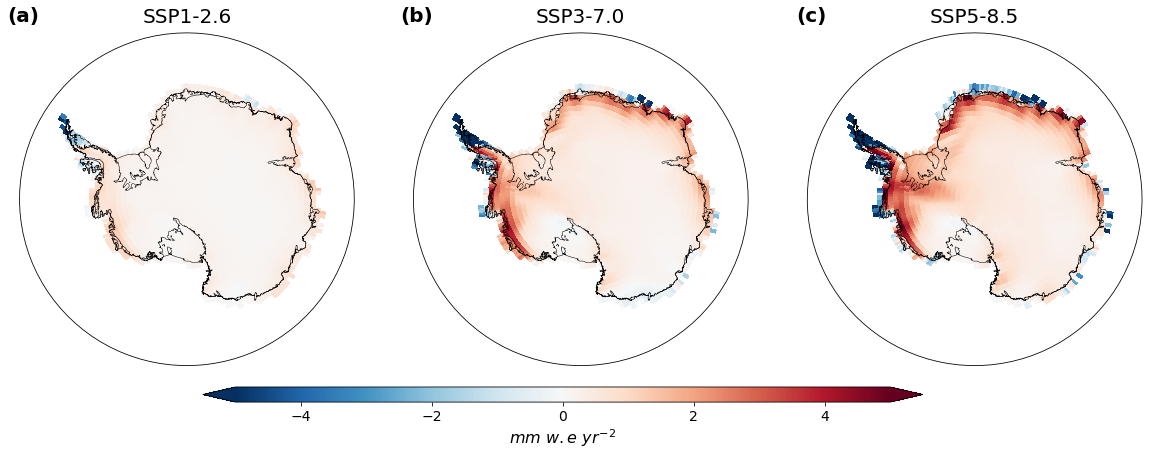

In [22]:
fig = plt.figure(figsize = (20, 7))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0],projection=crs_sp)
plot_antarctica(ax1,-60)
im1 = ax1.pcolormesh(lon2, lat, ssp1_smb_trend, transform = crs_ll, cmap = 'RdBu_r',vmin = -5, vmax = 5)
ax1.set_title('SSP1-2.6', fontsize = 20)
ax1.text(0.05, 1.09, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax2 = plt.subplot(gs[1],projection=crs_sp)
plot_antarctica(ax2,-60)
im2 = ax2.pcolormesh(lon2, lat, ssp3_smb_trend, transform = crs_ll, cmap = 'RdBu_r',vmin = -5, vmax = 5)
ax2.set_title('SSP3-7.0', fontsize = 20)
ax2.text(0.05, 1.09, '(b)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')


ax3 = plt.subplot(gs[2],projection=crs_sp)
plot_antarctica(ax3,-60)
im2 = ax3.pcolormesh(lon2, lat, ssp5_smb_trend, transform = crs_ll, cmap = 'RdBu_r',vmin = -5, vmax = 5)
ax3.set_title('SSP5-8.5', fontsize = 20)
ax3.text(0.05, 1.09, '(c)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')


cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])
cb = fig.colorbar(im2, cax=cbar_ax, orientation = 'horizontal', extend = 'both')
cb.set_label(label='$mm~w.e~yr^{-2}$', size=16)
cb.ax.tick_params(labelsize=14)
plt.savefig('smb_future_trends.png', dpi = 300, bbox_inches = 'tight', transparent = True)



## Temperature change

In [34]:
def calculate_change(ts):
    first10 = ts.sel(year = slice(2015,2024))
    last10 = ts.sel(year = slice(2091,2100))
    change = last10.mean() - first10.mean()
    return change

Full ice sheet

In [42]:
ssp5_temp_ts_full = (ssp5_temp * cesm_ism).groupby(ssp5_temp.time.dt.year).mean().mean(dim = 'ensemble')
ssp5_temp_ts_full = (ssp5_temp_ts_full*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_ism)
ssp5_temp_change = calculate_change(ssp5_temp_ts_full)
print(f'SSP5 temperature change = {ssp5_temp_change.values:0.1f} ◦C')

ssp5_smb_ts_full, ssp5_trend, ssp5_trend_line = get_timeseries(ssp5_smb, cesm_ism)
ssp5_smb_change = calculate_change(ssp5_smb_ts_full)
print(f'SSP5 SMB change = {ssp5_smb_change.values:0.0f} Gt')

print(f'SSP5 dSMB/dT = {ssp5_smb_change.values/ssp5_temp_change.values:0.0f} Gt/◦C')

SSP5 temperature change = 6.5 ◦C
SSP5 SMB change = 599 Gt
SSP5 dSMB/dT = 92 Gt/◦C


In [43]:
ssp3_temp_ts_full = (ssp3_temp * cesm_ism).groupby(ssp3_temp.time.dt.year).mean().mean(dim = 'ensemble')
ssp3_temp_ts_full = (ssp3_temp_ts_full*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_ism)
ssp3_temp_change = calculate_change(ssp3_temp_ts_full)
print(f'SSP3 temperature change = {ssp3_temp_change.values:0.1f} ◦C')

ssp3_smb_ts_full, ssp3_trend, ssp3_trend_line = get_timeseries(ssp3_smb, cesm_ism)
ssp3_smb_change = calculate_change(ssp3_smb_ts_full)
print(f'SSP3 SMB change = {ssp3_smb_change.values:0.0f} Gt')

print(f'SSP3 dSMB/dT = {ssp3_smb_change.values/ssp3_temp_change.values:0.0f} Gt/◦C')

SSP3 temperature change = 4.5 ◦C
SSP3 SMB change = 557 Gt
SSP3 dSMB/dT = 125 Gt/◦C


In [44]:
ssp1_temp_ts_full = (ssp1_temp * cesm_ism).groupby(ssp1_temp.time.dt.year).mean().mean(dim = 'ensemble')
ssp1_temp_ts_full = (ssp1_temp_ts_full*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_ism)
ssp1_temp_change = calculate_change(ssp1_temp_ts_full)
print(f'SSP1 temperature change = {ssp1_temp_change.values:0.1f} ◦C')

ssp1_smb_ts_full, ssp1_trend, ssp1_trend_line = get_timeseries(ssp1_smb, cesm_ism)
ssp1_smb_change = calculate_change(ssp1_smb_ts_full)
print(f'SSP1 SMB change = {ssp1_smb_change.values:0.0f} Gt')

print(f'SSP1 dSMB/dT = {ssp1_smb_change.values/ssp1_temp_change.values:0.0f} Gt/◦C')

SSP1 temperature change = 1.5 ◦C
SSP1 SMB change = 265 Gt
SSP1 dSMB/dT = 173 Gt/◦C


grounded ice sheet

In [50]:
ssp1_smb_change_g = calculate_change(ssp1_smb_ts)
ssp1_temp_change_g = calculate_change(ssp1_temp_ts)
print(f'SSP1 dSMB/dT = {ssp1_smb_change_g.values/ssp1_temp_change_g.values:0.0f} Gt/◦C')

ssp3_smb_change_g = calculate_change(ssp3_smb_ts)
ssp3_temp_change_g = calculate_change(ssp3_temp_ts)
print(f'SSP3 dSMB/dT = {ssp3_smb_change_g.values/ssp3_temp_change_g.values:0.0f} Gt/◦C')

ssp5_smb_change_g = calculate_change(ssp5_smb_ts)
ssp5_temp_change_g = calculate_change(ssp5_temp_ts)
print(f'SSP5 dSMB/dT = {ssp5_smb_change_g.values/ssp5_temp_change_g.values:0.0f} Gt/◦C')

SSP1 dSMB/dT = 158 Gt/◦C
SSP3 dSMB/dT = 140 Gt/◦C
SSP5 dSMB/dT = 121 Gt/◦C


Ice shelves

In [51]:
ssp1_smb_change_is = calculate_change(ssp1_smb_ts_is)
ssp1_temp_change_is = calculate_change(ssp1_temp_ts_is)
print(f'SSP1 dSMB/dT = {ssp1_smb_change_is.values/ssp1_temp_change_is.values:0.0f} Gt/◦C')

ssp3_smb_change_is = calculate_change(ssp3_smb_ts_is)
ssp3_temp_change_is = calculate_change(ssp3_temp_ts_is)
print(f'SSP3 dSMB/dT = {ssp3_smb_change_is.values/ssp3_temp_change_is.values:0.0f} Gt/◦C')

ssp5_smb_change_is = calculate_change(ssp5_smb_ts_is)
ssp5_temp_change_is = calculate_change(ssp5_temp_ts_is)
print(f'SSP5 dSMB/dT = {ssp5_smb_change_is.values/ssp5_temp_change_is.values:0.0f} Gt/◦C')

SSP1 dSMB/dT = 7 Gt/◦C
SSP3 dSMB/dT = -33 Gt/◦C
SSP5 dSMB/dT = -53 Gt/◦C
